In [1]:
import os
import time
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

# wandb for tracking experiment and sweeping hyperparamters
import wandb
# pyyaml (yaml) :: parses configuration files (YAML files)
# see https://www.cloudbees.com/blog/yaml-tutorial-everything-you-need-get-started for more information on YAML files
import yaml 

# huggingface :: datasets : dataset-handling libraries from huggingface
from datasets import load_dataset
#from datasets.filesystems import S3FileSystem # for S3 interactions

# huggingface :: transformers : transformer, trainer and tokenizer objects for the actual training
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# nltk punkt sentence tokenizer, divides text into a list of sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!nvidia-smi

Wed Feb 22 02:00:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
path_to_config = "../configs/gpt2-refl-21-feb-2023.yaml"
# open yaml config as a strema and load into config_dict
with open(path_to_config, "r") as stream:
    try:
        config_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print("Configuration load failed!")
        print(exc)

In [5]:
df = pd.read_csv(config_dict["data_train_path"])
df_val = pd.read_csv(config_dict["data_validation_path"])

In [6]:
df.dropna(inplace=True)  # drop NA values
triplets = df.triplet.copy()  # copy over triplets

In [7]:
val_triplets = df_val.triplet.copy()  # validation triplets

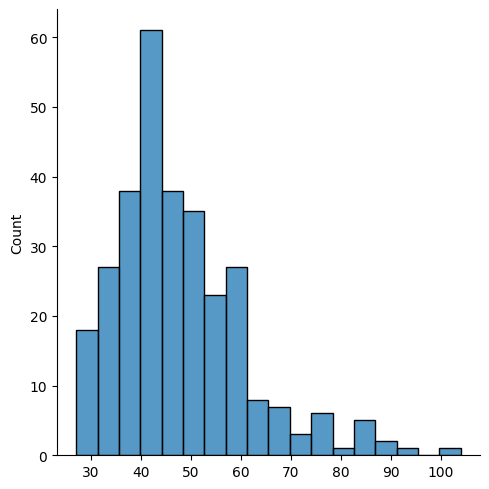

In [8]:
# how long is our training data?
doc_lengths = []
for triplet in triplets:
    tokens = nltk.word_tokenize(triplet)
    doc_lengths.append(len(tokens))
doc_lengths = np.asarray(doc_lengths)
sns.displot(doc_lengths)

In [9]:
np.average(doc_lengths)
# on average, we have ~47.5 tokens per entry, a good thing for GPT2 embedding size of 768 in gpt-small

47.57807308970099

In [10]:
model_name = config_dict['model_name']

In [11]:
# load gpt-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [13]:
# config to instantiate model
configuration = GPT2Config.from_pretrained(model_name, output_hidden_states=False)

In [14]:
# instantiate model
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)

In [15]:
# resize token embeddings for our custom tokens (e.g. bos_token)
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [16]:
device = torch.device("cuda")

In [17]:
# sends model to current device - in this case CUDA
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [18]:
# Set the seed value
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [19]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [20]:
sweep_config = {
    'method': 'random',
    'name': 'gpt2 random sweep - with validation',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    
    # parameters is the nested dictionary of hyperparameters we are sweeping
    'parameters': 
    {
        'batch_size': {'values': [1, 2, 3]},
        'epochs': {'values': [5, 10, 15]},
        'learning_rate': {'max': 0.1, 'min': 0.0001},
        'epsilon': {'values': [1e-7]},
        'warmup_steps': {'values': [1e2]}
     }
}

In [21]:
sweep_id = wandb.sweep(sweep_config, project="gpt2-sweep-reflector")

Create sweep with ID: tclin8lb
Sweep URL: https://wandb.ai/andrewbrown/gpt2-sweep-reflector/sweeps/tclin8lb


In [22]:
class GPT2Dataset(Dataset):
    # Inherits Dataset from PyTorch, a data primitive which
    # stores samples and corresponding labels
    # custom Dataset needs init, len, and getitem
    # init runs once when instantiating Dataset object
    def __init__(self, txt_list, tokenzier, gpt2_type='gpt2', max_length=768):
        self.tokenizer = tokenizer,
        self.input_ids = []
        self.attn_masks = []
        
        # for each text list, encode it using tokenizer then unpacl encodings dict into:
        # input_ids: numerical representations of our tokens
        # attn_masks: indicates which tokens should be attended to (and which are pads)
        for txt in txt_list:
            # tokenize the txt with a custom start and end token
            # encodings dict contains both our token input ids and attention mask
            # truncation will clip sentences that are too long
            # padding adds pad tokens until we reach max input sentence length 768
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    # overrides len() to returns the number of samples in our dataset
    def __len__(self):
        return len(self.input_ids)
    # loads and returns a sample from dataset at given index idx
    # sometimes we need to do type swapping in getitem, but not here
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
            
def build_dataset(triplets, tokenizer, batch_size, max_length=768, mode="random"):
    dataset = GPT2Dataset(triplets, tokenizer, max_length=768)
    if mode == "sample":
        return DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)
    else:
        return DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

In [23]:
def train_epoch(model, train_dataloader, optimizer, scheduler):
    training_stats = []

    model = model.to(device)

    """
    Training for one epoch
    """
    wandb.watch(model)
    print("---Training Epoch...---")

    # start epoch timer
    t0 = time.time()

    total_train_loss = 0

    # sets model into train mode, not actual backprop
    # dropout and batchnorm behave differently
    # opposite of model.eval() for inference mode
    model.train()

    for step, batch in enumerate(train_dataloader):
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)

        # clear any gradients from model tensors
        # prevents any gradient accumulation
        model.zero_grad()

        # forward pass
        outputs = model(input_tokens,
                        labels=label_tokens,
                        attention_mask=attn_masks,
                        token_type_ids=None
                       )

        # grab loss from outputs
        loss = outputs[0]

        batch_loss = loss.item()  # detach from device with item
        total_train_loss += batch_loss

        # backpropagation step
        # computes dloss/dx for every parameter x which has requires_grad=True.
        # updates gradient values
        # x.grad += dloss/dx
        loss.backward()
        
        # step scheduler
        # tells scheduler to increase learning rate
        # using our warmup steps
        scheduler.step()

        # step optimizer
        # updates the value of x using the gradient x.grad
        # x += -lr * x.grad
        optimizer.step()



    print("---Done Training Epoch!---")
    # measure how long the epoch took
    training_time = format_time(time.time() - t0)

    print(f"---Training epoch took {training_time} ---")
    # calculate average loss over all batches
    return total_train_loss / len(train_dataloader)

In [24]:
def validate_epoch(model, validation_dataloader):
    """
    Validation
    """
    print("---Running Validation...---")
    
    # start batch timer
    t0 = time.time()
    
    # set model to inference mode
    model.eval()
    
    total_eval_loss = 0
    
    # evaluate data for one epoch
    for batch in validation_dataloader:
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)
        
        # freeze gradients
        with torch.no_grad():
            outputs = model(input_tokens,
                            attention_mask=attn_masks,
                            labels=label_tokens)
            
            loss = outputs[0]
        
        batch_loss = loss.item()
        total_eval_loss += batch_loss
    
    # measure how long the epoch took
    validation_time = format_time(time.time() - t0)
    
    print("---Done Validation!---")
    return total_eval_loss / len(validation_dataloader)

In [25]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
def build_optimizer(model, learning_rate, epsilon):
    return AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

In [26]:
def build_learning_rate_scheduler(optimizer, warmup_steps, num_examples, epochs):
    # Create learning rate scheduler
    # we schedule learning rate using optimzer, num_warmup steps, and num_training steps
    total_steps = num_examples * epochs
    return get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

In [27]:
def train():
    # Initialize a new wandb run
    with wandb.init(project="gpt2-sweep-reflector", notes="Trying to sweep gpt2 reflector",tags=["gpt2", "reflector", "sweep"]):
        # If called by wandb.agent, as below,
        print("starting sweep")
        # this config will be set by Sweep Controller
        batch_size = wandb.config.batch_size
        learning_rate = wandb.config.learning_rate
        epsilon = wandb.config.epsilon
        epochs = wandb.config.epochs
        warmup_steps = wandb.config.warmup_steps

        print("loaded config sweep")

        train_dataloader = build_dataset(triplets, tokenizer, batch_size, max_length=768, mode="random")
        validation_dataloader = build_dataset(val_triplets, tokenizer, batch_size, max_length=768, mode="sequential")
        # not varying model architecture
        #network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(model, learning_rate, epsilon)
        scheduler = build_learning_rate_scheduler(optimizer, warmup_steps, len(train_dataloader), epochs)
        print("Starting training")

            
        for epoch in range(epochs):
            train_loss = train_epoch(model, train_dataloader, optimizer, scheduler)
            val_loss = validate_epoch(model, validation_dataloader)
            wandb.log({
                'epoch': epoch, 
                'train_loss': train_loss,
                'val_loss': val_loss
            })
        wandb.alert(
            title="Done Sweep! -  Feb 21", 
            text=f"Finished sweeping gpt-2, check out validation results"
        )

In [ ]:
wandb.agent(sweep_id, train, count=10)

wandb: Agent Starting Run: d6rzao0j with config:
wandb: 	batch_size: 3
wandb: 	epochs: 10
wandb: 	epsilon: 1e-07
wandb: 	learning_rate: 0.09837234475193338
wandb: 	warmup_steps: 100
wandb: Currently logged in as: andrewbrown. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
time="2023-02-22T02:01:10Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


starting sweep
loaded config sweep


/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Starting training
---Training Epoch...---


/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


---Done Training Epoch!---
---Training epoch took 0:01:09 ---
---Running Validation...---
---Done Validation!---
---Training Epoch...---


In [40]:
# saving and loading the finetuned model
output_dir = '../../Output/model/gpt-feb6/'
tokenizer_dir = '../../Output/model/gpt-tokenizer-feb6/'

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create output directory if needed
if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir)
    
    
print(f"Saving model to {output_dir}")

Saving model to ../../Output/model/gpt-feb5/


In [41]:
# Save trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(tokenizer_dir)

('../../Output/model/gpt-tokenizer-feb5/tokenizer_config.json',
 '../../Output/model/gpt-tokenizer-feb5/special_tokens_map.json',
 '../../Output/model/gpt-tokenizer-feb5/vocab.json',
 '../../Output/model/gpt-tokenizer-feb5/merges.txt',
 '../../Output/model/gpt-tokenizer-feb5/added_tokens.json')

In [43]:
# save training arguments with trained model
torch.save(model.state_dict(), os.path.join(output_dir, 'training_args.bin'))

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)